## [作業重點]
了解如何使用 Sklearn 中的 hyper-parameter search 找出最佳的超參數

### 作業
請使用不同的資料集，並使用 hyper-parameter search 的方式，看能不能找出最佳的超參數組合

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_selection import RFECV, SelectFromModel

from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus

import warnings
warnings.filterwarnings(action='ignore')

## Define the common functions

In [4]:
def report_overview(df):
    #df.describe()
    overview = df.describe().T.reset_index()
    overview = overview.rename(columns={"index":"column"})

    # na percentage
    na_percentage= df.apply(lambda c: (c.isna().sum()/len(c))*100)
    na_percentage = na_percentage.reset_index()
    na_percentage.columns=["column", "na%"]
    overview = pd.merge(overview, na_percentage, on='column')
    # dtype
    dtype = df.dtypes.reset_index()
    dtype.columns=['column', 'dtype']
    overview = pd.merge(overview, dtype, on='column')
    # 3 samples
    sample= df.sample(n=3,  random_state=1).T.reset_index()
    sample = sample.rename(columns={"index":"column"})
    overview = pd.merge(overview, sample, on='column')
    return overview

In [5]:
# draw the distribution of each column
def draw_dist(data, n_row, n_col, figsize):
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize) 
    i=0
    for x in range(n_row):
        for y in range(n_col):
            sns.distplot(train.iloc[:, i], kde=False, ax=ax[x, y])
            i = i+1
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

In [6]:
# draw the heatmap
def draw_heatmap(data, figsize):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', ax=ax)
    plt.show()

In [7]:
def train_model(data, target, model, param_grid):
    train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.25, random_state=1234)
    fselect = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
    fselect.fit(train_X, train_y)
    
    print("The number of selected features with cross-validation: {}".format(fselect.n_features_))
    print("The mask of selected features: {}".format(fselect.support_))
    print("The selected features:{}".format(train.columns[fselect.support_]))
    print("The feature ranking: {}".format(fselect.ranking_))
    
    select_f = train.columns[fselect.support_]
    select_train = mm_train.iloc[:, select_f]
    
    train_X, test_X, train_y, test_y = train_test_split(select_train, trainLabels, test_size=0.25, random_state=1234)
    
    model_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=1, cv=5, verbose=1)
    model_search.fit(train_X, train_y)            
    predict_y = model_search.predict(test_X)
    
    print("Best Accuracy: {} using {}".format(model_search.best_score_, model_search.best_params_))
    

## Read data

In [103]:
# read dataset
DATA_ROOT = os.path.join(os.getcwd(), "data")
train_offline =  pd.read_csv(os.path.join(DATA_ROOT, "train_offline.csv"))
test_offline = pd.read_csv(os.path.join(DATA_ROOT,"test_offline.csv"))

print(train_offline.shape)
print(test_offline.shape)

(1160742, 7)
(594142, 6)


In [137]:
# w/o coupon, remove it
train = train_offline[~train_offline['Coupon_id'].isnull()]  
print(train.shape)

# convert date type columns
train['Date_received'] = pd.to_datetime(train['Date_received'], format='%Y%m%d', errors='ignore')
train['Date'] = pd.to_datetime(train['Date'], format='%Y%m%d', errors='ignore')

# couple w/o buy, label =0
# buy w/ couple later than 15 days, label= 0
# buy w/ couple in 15 days label= 1
def label_transaction(x):
    if pd.isna(x['Date']) or (x['Date']-x['Date_received'] > pd.Timedelta(15, 'D')):
        return 0
    elif x['Date'] - x['Date_received'] <= pd.Timedelta(15, 'D'):
        return 1
    else:
        return -1

train_labels = train.apply(label_transaction, axis =1)

(746969, 7)


In [138]:
print(train.shape)
print(train_labels[train_labels==0].shape)
print(train_labels[train_labels==1].shape)
print(train_labels[train_labels==-1].shape)

(746969, 7)
(710665,)
(36304,)
(0,)


## Explore the data

 - No NA data
 - Train data shape is (1000, 40)
 - The std/max/min of column 4, 6, 7, 12, 14, 18, 22, 23, 28, 29, 32, 34, 36, 38, 38 39 are notable  

In [121]:
report_overview(train)

,column,count,mean,std,min,25%,50%,75%,max,na%,dtype,507,818,452
0,0,1000.0,0.025596,1.008282,-3.365711,-0.669010,0.027895,0.762520,3.326246,0.0,float64,-0.054689,0.711375,-0.547347
1,1,1000.0,-0.024526,1.016298,-3.492086,-0.693937,-0.033194,0.682753,3.583870,0.0,float64,-0.180668,0.573607,0.271608
2,2,1000.0,-0.024088,0.979109,-2.695602,-0.698830,0.008145,0.661434,2.546507,0.0,float64,-1.007788,-0.481991,-0.394293
3,3,1000.0,-0.002271,0.970575,-3.460471,-0.617557,0.002327,0.640743,3.088738,0.0,float64,-0.655973,1.404482,-0.187581
4,4,1000.0,1.092329,4.538834,-16.421901,-1.801997,0.862818,3.843172,17.565345,0.0,float64,1.808360,-2.767393,1.337164
5,5,1000.0,-0.006250,0.989128,-3.041250,-0.732265,0.027041,0.671456,3.102997,0.0,float64,0.240109,0.570277,1.119694
6,6,1000.0,0.497342,2.118819,-7.224761,-0.838619,0.582321,1.913664,7.592666,0.0,float64,5.586617,5.530548,3.380823
7,7,1000.0,-0.037883,2.232256,-6.509084,-1.604037,0.018809,1.438304,7.130097,0.0,float64,-1.562269,-1.984976,-1.460562
8,8,1000.0,0.026391,1.001064,-3.145588,-0.677562,0.022092,0.741310,3.145258,0.0,float64,0.562751,-0.434252,0.767648
9,9,1000.0,-0.003597,1.013520,-2.749812,-0.682220,-0.036110,0.665364,3.919426,0.0,float64,0.189091,-0.018959,-0.653800


In [122]:
report_overview(trainLabels)

,column,count,mean,std,min,25%,50%,75%,max,na%,dtype,507,818,452
0,0,1000.0,0.51,0.50015,0.0,0.0,1.0,1.0,1.0,0.0,int64,0,0,0


 - The distribution looks even

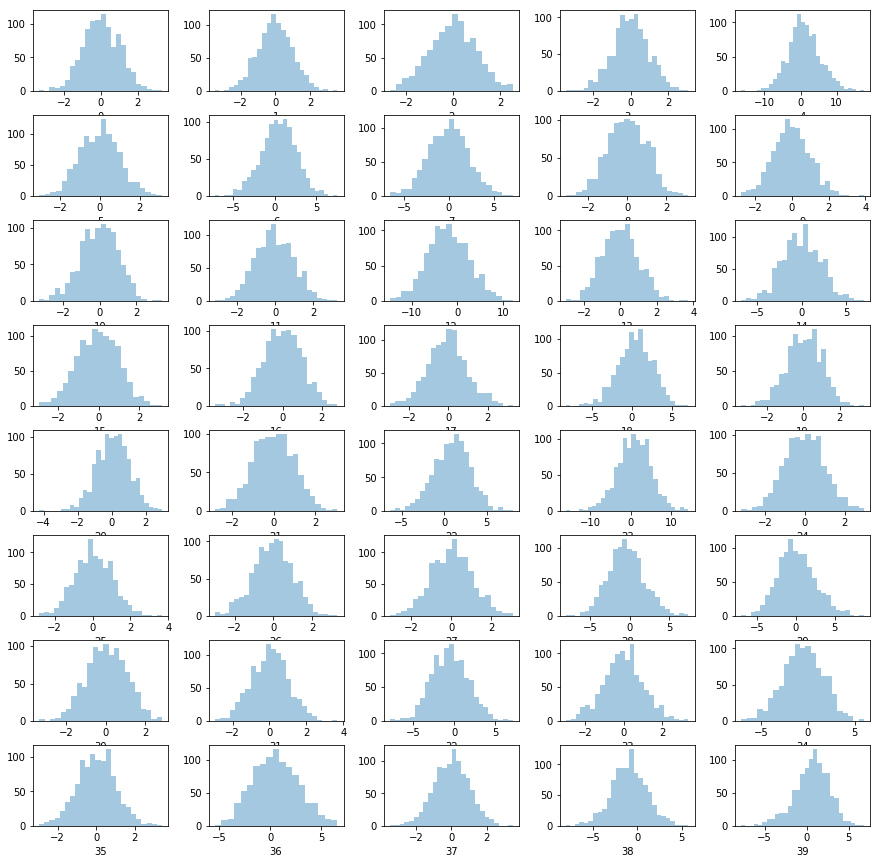

In [123]:
draw_dist(train, 8, 5, figsize=(15,15))

In [158]:
scaler=MinMaxScaler()
mm_train = scaler.fit_transform(train)
mm_train=pd.DataFrame(mm_train)

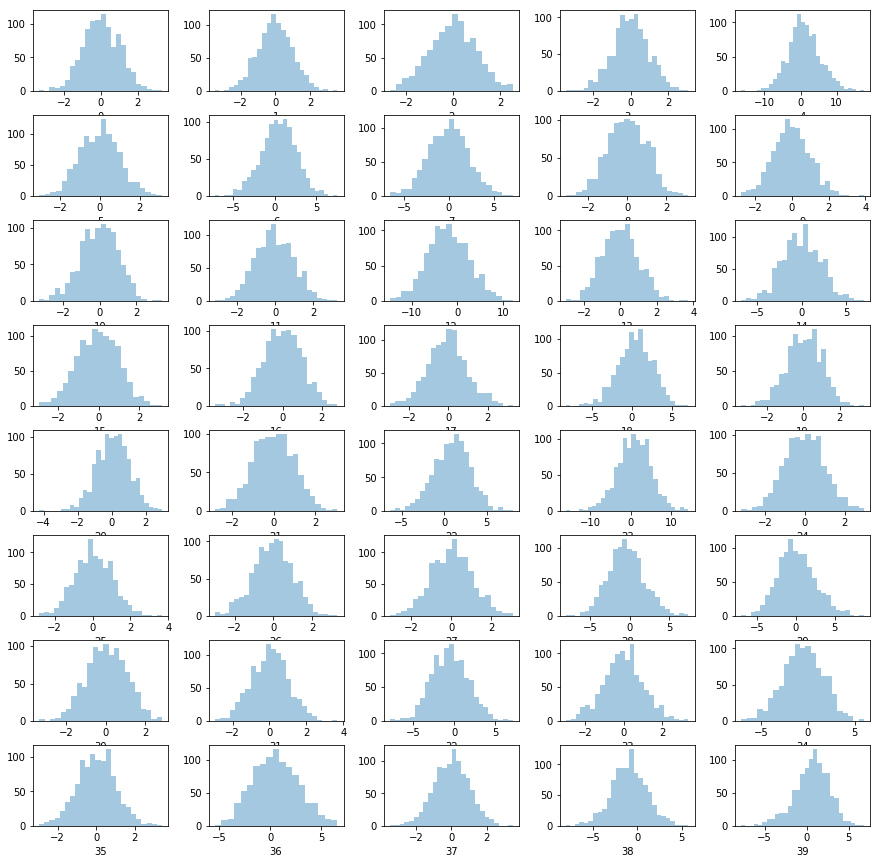

In [126]:
draw_dist(mm_train, 8, 5, figsize=(15,15))

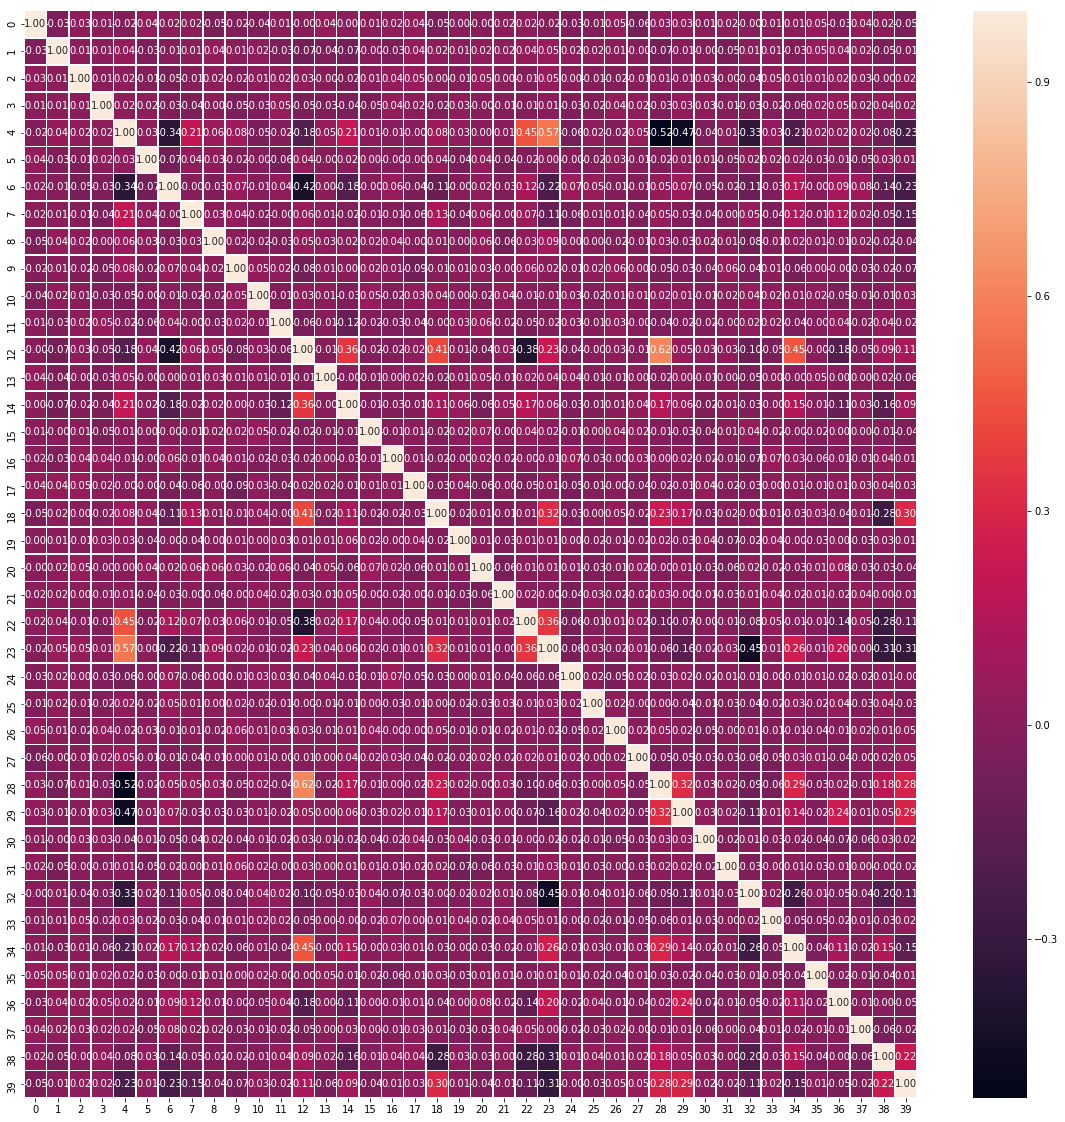

In [127]:
draw_heatmap(mm_train,figsize=(20, 20))

## Train Model 
 - Use GradientBoostingClassifier
 - Select features in EREFCV
 - Search hyper parameter in GridSearchCV

In [195]:
train_X, test_X, train_y, test_y = train_test_split(mm_train, trainLabels, test_size=0.25, random_state=1234)
model = GradientBoostingClassifier()

- Select features by using EREFCV 

In [196]:
fselect_1 = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
fselect_1.fit(train_X, train_y)

RFECV(cv=5,
   estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [197]:
print("The number of selected features with cross-validation: {}".format(fselect_1.n_features_))
print("The mask of selected features: {}".format(fselect_1.support_))
print("The selected features:{}".format(train.columns[fselect_1.support_]))
print("The feature ranking: {}".format(fselect_1.ranking_))

The number of selected features with cross-validation: 16
The mask of selected features: [False False False False  True False  True  True False False False  True
  True False  True False False False  True False False False  True  True
 False False False False  True  True False False  True False  True False
  True False  True  True]
The selected features:Int64Index([4, 6, 7, 11, 12, 14, 18, 22, 23, 28, 29, 32, 34, 36, 38, 39], dtype='int64')
The feature ranking: [11 13  2  9  1 22  1  1  4 20 17  1  1  5  1  6 23  7  1 24 10 12  1  1
 18  3 19 14  1  1 15 16  1  8  1 21  1 25  1  1]


In [198]:
select_f = mm_train.columns[fselect_1.support_]
select_train_1 = mm_train.iloc[:, select_f]

In [199]:
train_X, test_X, train_y, test_y = train_test_split(select_train_1, trainLabels, test_size=0.25, random_state=1234)

param_grid={"n_estimators":[20, 50,100],
          "learning_rate":[0.5, 1, 1.5]}
model_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=1, cv=5, verbose=1)
model_search.fit(train_X, train_y)            
predict_y = model_search.predict(test_X)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.2s finished


In [200]:
print("Best Accuracy: {} using {}".format(model_search.best_score_, model_search.best_params_))

Best Accuracy: 0.8973333333333333 using {'learning_rate': 0.5, 'n_estimators': 100}


## Refit Model based on the best parameters

In [201]:
train_X, test_X, train_y, test_y = train_test_split(select_train_1, trainLabels, test_size=0.25, random_state=1234)
model_1 = GradientBoostingClassifier(learning_rate=0.5, n_estimators=100)
model_1.fit(train_X, train_y)
acc =accuracy_score(predict_y, test_y)
print("Best Accuracy={}".format(acc))

Best Accuracy=0.876


## Train Model 
 - Use RandomForestClassifier
 - Select features in EREFCV
 - Search hyper parameter in RandomizedSearchCV

In [202]:
train_X, test_X, train_y, test_y = train_test_split(mm_train, trainLabels, test_size=0.25, random_state=1234)
model = RandomForestClassifier()

In [203]:
fselect_2 = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
fselect_2.fit(train_X, train_y)

RFECV(cv=5,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

In [204]:
print("The number of selected features with cross-validation: {}".format(fselect_2.n_features_))
print("The mask of selected features: {}".format(fselect_2.support_))
print("The selected features:{}".format(train.columns[fselect_2.support_]))
print("The feature ranking: {}".format(fselect_2.ranking_))

The number of selected features with cross-validation: 10
The mask of selected features: [False False False False  True False  True False False False False False
  True False  True False False False  True False False False False False
 False False False False  True  True False False  True False False False
  True False False  True]
The selected features:Int64Index([4, 6, 12, 14, 18, 28, 29, 32, 36, 39], dtype='int64')
The feature ranking: [ 7 12 15 28  1 21  1  6  8 16 13 14  1 24  1 11 17 27  1 30 22 31  5  4
 29  9 25 26  1  1 20 23  1 10  2 19  1 18  3  1]


In [205]:
select_f = mm_train.columns[fselect_2.support_]
select_train_2 = mm_train.iloc[:, select_f]

In [206]:
train_X, test_X, train_y, test_y = train_test_split(select_train_2, trainLabels, test_size=0.25, random_state=1234)
param_distributions  ={"n_estimators":[20, 50,100],
          "max_depth":[4, 6, 8]}
model_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, scoring='accuracy', n_jobs=1, cv=5, verbose=1, random_state=7)
model_search.fit(train_X, train_y)            
predict_y = model_search.predict(test_X)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.8s finished


In [207]:
print("Best Accuracy: {} using {}".format(model_search.best_score_, model_search.best_params_))

Best Accuracy: 0.8826666666666667 using {'n_estimators': 100, 'max_depth': 8}


##  Refit Model based on the best parameters

In [208]:
train_X, test_X, train_y, test_y = train_test_split(select_train_2, trainLabels, test_size=0.25, random_state=1234)
model_2 = RandomForestClassifier(max_depth=8, n_estimators=100)
model_2.fit(train_X, train_y)
acc =accuracy_score(predict_y, test_y)
print("Best Accuracy={}".format(acc))

Best Accuracy=0.816


## Test Model
Becasue  model_1 provides better accurancy. Submit the prediction according to 
 - Use GradientBoostingClassifier using {'learning_rate': 0.5, 'n_estimators': 100}
 - Select features in EREFCV
 - Search hyper parameter in GridSearchCV

In [215]:
mm_test = scaler.fit_transform(test)
mm_test=pd.DataFrame(mm_test)

select_f = mm_test.columns[fselect_1.support_]
select_test_1 = mm_test.iloc[:, select_f]
predict_test = model_1.predict(select_test_1)

In [227]:
submit = pd.DataFrame(predict_test)

submit = submit.reset_index()
submit.rename(columns={"index":"Id", 0:"Solution"}, inplace=True)
submit['Id'] = submit['Id'] +1
submit.to_csv(os.path.join(data_dir, "submit.csv"), header=True, index=False)